# Model 3a - kNNRegressor with standardization & hyperparameter tuning (with 5-fold cross-validation)

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score


from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Safety Factor Class,Safety Factor Class_1,Safety Factor Class_2,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),Length Line of Intersection (m),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,11.0,6.0,1.05,6349.248707,171.429715,31.846178,161.418240,56.856884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,13.0,7.0,1.35,7701.148241,207.931003,31.905513,168.542870,56.762278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,9.0,5.0,0.75,2341.641868,63.224330,36.973415,150.874977,49.879923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,7.0,4.0,0.75,155.345062,4.194317,54.969435,195.219985,36.636928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,13.0,7.0,1.35,7468.340623,201.645197,29.688564,178.765625,60.571151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 90)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 9)


,Safety Factor,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,1.082239,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,1.203906,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,0.896601,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,0.680996,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,1.263948,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 9)


## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split. 

In [6]:
num_samples = []

r2_train_subsample_list = []
rmse_train_subsample_list = []
r2_test_subsample_list = []
rmse_test_subsample_list = []

random_state_val = [0,1,42,123]

# hyperparameter grid for kNNRegressor
param_grid = {"kneighborsregressor__n_neighbors": np.arange(2,20,1)}

for x in range(0,4):

    # dataset up to 4950 points
    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        # train/test split with different random_state values (0, 1, 42, and 123)
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Safety Factor"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Safety Factor"]]
        y_test_subsample = np.ravel(y_test_subsample)

        # train knn model with hyperparameter tuning & 5 fold cv
        # make pipeline for knn with pre-processing (standardizing the data)
        pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
        grid_search = GridSearchCV(pipe_knn, param_grid,cv=5)
        grid_search.fit(x_train_subsample, y_train_subsample)

        ypred_knn = grid_search.predict(x_train_subsample)
        ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))

        # training r2 and rmse
        r2_train_subsample = grid_search.score(x_train_subsample,y_train_subsample)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))

        # append training r2, rmse, and mape to their respective lists
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
        mape_train_subsample_list.append(mape_train_subsample)

       
        # test the knn model
        # predict y test
        ypred_test_knn = grid_search.predict(x_test_subsample)
        ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))

        r2_test_subsample = grid_search.score(x_test_subsample,y_test_subsample)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))
        mape_test_subsample = mean_absolute_percentage_error(y_test_subsample,ypred_test_knn)

        # append testing r2, rmse, and mape to their respective lists
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
        mape_test_subsample_list.append(mape_test_subsample)
        
        print(i)
        
    # entire dataset (4992 data points)
    num_samples.append(len(data_model.index))
    
    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123)
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Safety Factor"]]
    y_train_subsample = np.ravel(y_train_subsample)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Safety Factor"]]
    y_test_subsample = np.ravel(y_test_subsample)

    # hyperparameter tuning (n_neighbors hyperparameter)
    # make pipeline for knn with pre-processing (standardizing the data)
    pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
    grid_search = GridSearchCV(pipe_knn, param_grid,cv=5)
    grid_search.fit(x_train_subsample, y_train_subsample)

    ypred_knn = grid_search.predict(x_train_subsample)
    ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))

    # training r2 and rmse
    r2_train_subsample = grid_search.score(x_train_subsample,y_train_subsample)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))

    # append training r2 and rmse to their respective lists
    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)

    # test the knn model
    # predict y test
    ypred_test_knn = grid_search.predict(x_test_subsample)
    ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))

    # test r2 and rmse
    r2_test_subsample = grid_search.score(x_test_subsample,y_test_subsample)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))

    # append test r2 and rmse to their respective lists
    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
100
150
200
250
300
350
400
450
500
550
600
650
700
750


In [7]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)

In [8]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,r2_train_subsample_list,rmse_train_subsample_list,r2_test_subsample_list,rmse_test_subsample_list],axis=1)

In [11]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

,0,0,0,0,0,0,0,0
391,4800,35,0.810816,0.233470,0.068584,0.841959,0.168348,0.080998
392,4850,36,0.836242,0.211478,0.068467,0.628693,0.301529,0.079951
393,4900,36,0.814609,0.219710,0.069961,0.620575,0.331081,0.080125
394,4950,36,0.791725,0.237930,0.069133,0.754944,0.240463,0.081883
395,4992,37,0.811080,0.229914,0.068506,0.822682,0.192571,0.079940


In [12]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])


(0.0, 1.0)

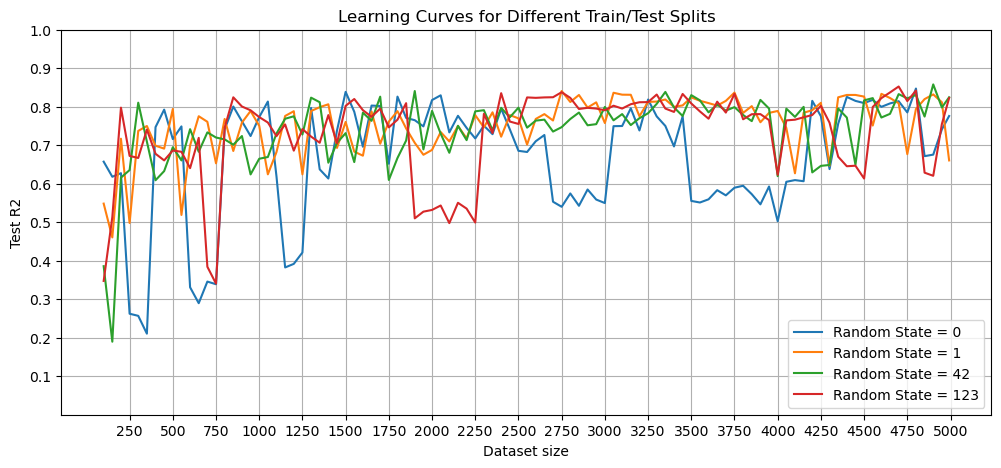

In [14]:
# plot learning curves for different train/test splits for test R2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x185c9ccba30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

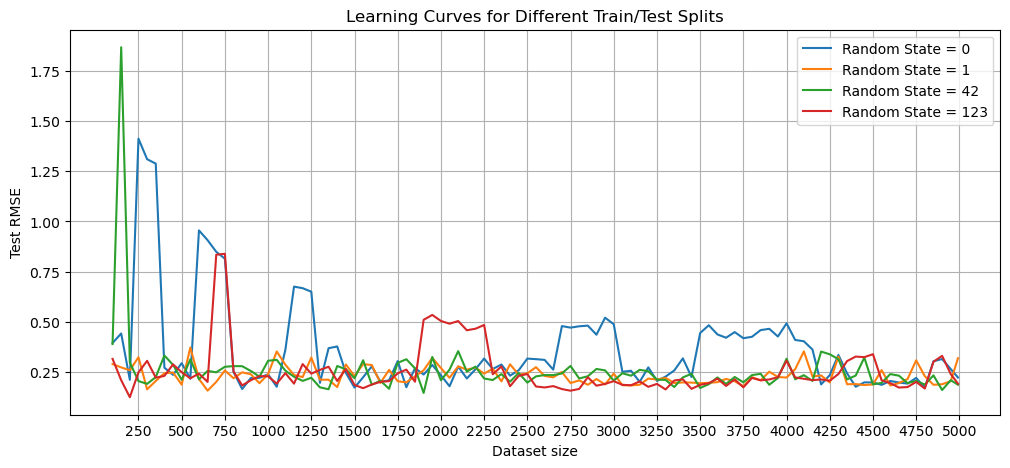

In [15]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [16]:
# train R2 - test R2
randomstate0_R2diff = randomstate0_rslts_pd['R2_train_subsample'] - randomstate0_rslts_pd['R2_test_subsample']
randomstate1_R2diff = randomstate1_rslts_pd['R2_train_subsample'] - randomstate1_rslts_pd['R2_test_subsample']
randomstate42_R2diff = randomstate42_rslts_pd['R2_train_subsample'] - randomstate42_rslts_pd['R2_test_subsample']
randomstate123_R2diff = randomstate123_rslts_pd['R2_train_subsample'] - randomstate123_rslts_pd['R2_test_subsample']

# test RMSE - train RMSE
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']



([<matplotlib.axis.XTick at 0x185c9e02880>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

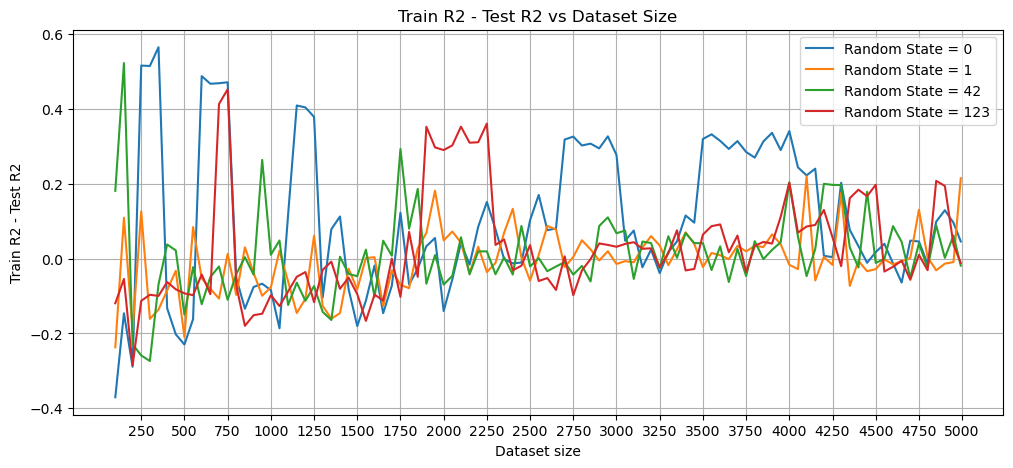

In [17]:
# plot R2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x185c9b52e50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

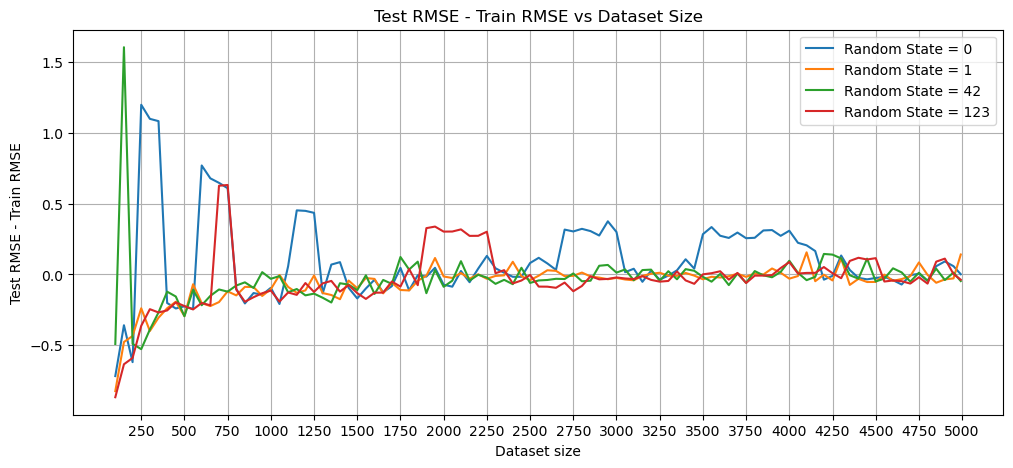

In [18]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [19]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,...,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample
0,100.0,2.0,0.286933,1.112742,0.165634,0.657277,0.395026,0.226057,100.0,2.0,...,0.389794,0.199468,100.0,2.0,0.228055,1.182997,0.189090,0.347538,0.316039,0.191454
1,150.0,3.0,0.472012,0.801079,0.131222,0.618080,0.442312,0.177847,150.0,3.0,...,1.867195,0.169648,150.0,3.0,0.458943,0.844074,0.144836,0.513367,0.209848,0.128898
2,200.0,3.0,0.338445,0.830969,0.150903,0.627336,0.211714,0.139403,200.0,3.0,...,0.298132,0.190240,200.0,3.0,0.512037,0.714901,0.131787,0.797573,0.125147,0.094602
3,250.0,3.0,0.777812,0.214820,0.111902,0.262326,1.412161,0.145185,250.0,3.0,...,0.205415,0.156945,250.0,3.0,0.559457,0.611635,0.114245,0.672268,0.248820,0.159451
4,300.0,3.0,0.771207,0.211784,0.107634,0.256846,1.309807,0.146763,300.0,3.0,...,0.191569,0.119147,300.0,3.0,0.570224,0.551756,0.107020,0.666941,0.306257,0.136266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800.0,35.0,0.833116,0.217895,0.067864,0.847244,0.172405,0.083582,4800.0,35.0,...,0.188301,0.080869,4800.0,35.0,0.810816,0.233470,0.068584,0.841959,0.168348,0.080998
95,4850.0,36.0,0.770380,0.246234,0.071150,0.671600,0.304030,0.084539,4850.0,36.0,...,0.233861,0.088403,4850.0,36.0,0.836242,0.211478,0.068467,0.628693,0.301529,0.079951
96,4900.0,36.0,0.804651,0.223570,0.068901,0.675578,0.315224,0.083658,4900.0,36.0,...,0.160982,0.082685,4900.0,36.0,0.814609,0.219710,0.069961,0.620575,0.331081,0.080125
97,4950.0,36.0,0.836654,0.207096,0.067347,0.741133,0.265092,0.084985,4950.0,36.0,...,0.209884,0.086848,4950.0,36.0,0.791725,0.237930,0.069133,0.754944,0.240463,0.081883


In [20]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model3a_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model3a_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()